# MNIST Deep Neural Network

Description: Using DNN (base sequential) and CNN (with sequential) to detect number. This MNIST dataset is commonly used on many projects and a topic that has been covered multiple times, but this time using my knowledge in CNN to build a deep neural network.


Steps:
1. Specify Version
2. Import Libraries
3. Load MNIST 
4. Build Model
5. Compile Model
6. Train Model
7. Evaluate Model
8. Visualize Results
9. Insights and Recommendations

## Import Libraries
    numpy for mathematics
    matplotlib for visualization
    tensorflow for Deep Neural Network
    keras is extension for tensorflow
    
    Sequential means the model is in sequence (orderly)
        This is simplist DNN layers transition from left to right
    
    Dense means that layer is fully connected
    Flatten means 2 dimension became 1 dimension for layer use
    
    Sequential DNN
    create model (CNN) -> hidden layers (1,2,3, Flatten -> Dense) -> output
    
    MNIST 
    28x28 pixels =784 | (28,28) img size, 784 features
    0-9 number img | 10 classes
    60,000 img training set | 10,000 img testing set
    0(white)-255(black) pixel value 

    UMAP and plotly + PCA reduction
    even more detailed visualization using UMAP
    -rotate, zoom, click label, various ways to visualize

In [1]:
import numpy as np # math
import pandas as pd # read csv
from sklearn.model_selection import train_test_split # split data
import matplotlib.pyplot as plt # visualization
import tensorflow as tf # deep learning
import seaborn as sns # visualization extension
from sklearn.metrics import confusion_matrix # metrics
from tensorflow.keras.models import Sequential # model, tf extension
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Lambda, Dropout # layers, tf extension
from keras.layers import Layer
from tensorflow.keras.datasets import mnist # mnist labeled dataset
from sklearn.decomposition import PCA # dimensional reduction
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import plotly.express as px # for 3D interactive plotting

In [2]:
pip install umap-learn # in order to use umap visualization, install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import umap # for 3D interactive plotting

## Load MNIST

In [4]:
# Load the data from Kaggle files
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# Separate features and labels in the training data
x_train = train.drop(columns=['label']).values  # Drop 'label' column for features
y_train = train['label'].values  # 'label' column for labels

# Normalize the data to range 0-1
x_train = x_train / 255.0
x_test = test.values / 255.0

# Reshape data to match the original MNIST dataset format (28x28 pixels)
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

# Optionally, split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Print shapes to confirm
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)


Shape of x_train: (37800, 28, 28)
Shape of y_train: (37800,)
Shape of x_val: (4200, 28, 28)
Shape of y_val: (4200,)
Shape of x_test: (28000, 28, 28)


Above, is the split of train and test, which most of the work is already done by existing files from test.csv and train.csv, saving time for not having to split into separate subsets. Validation set is made, though with the simplicity of the model, it may be optional.

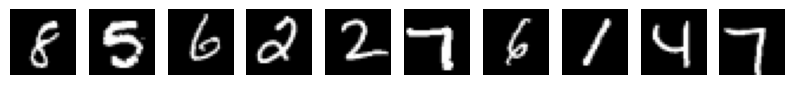

In [5]:
# Display the first 10 images in the training set
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)  # 1 row, 10 columns
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
plt.show()

Above, is the first ten images from the training set to get general sense of the image quality, variety, and visual analysis

## Build Model

In [6]:
# Define the custom sparse categorical crossentropy loss function
def custom_sparse_categorical_crossentropy(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

# custom activation function
def custom_leaky_relu(x, alpha=0.01):
    """
    Apply the Leaky ReLU activation function.

    Parameters:
    x (np.ndarray): Input values.
    alpha (float): Slope for negative values.

    Returns:
    np.ndarray: Output after applying Leaky ReLU.
    """
    return tf.where(x > 0, x, alpha * x)

# dense and leakyrelu together
class DenseLeakyReLU(Layer):
    def __init__(self, units, alpha=0.01, **kwargs):
        super(DenseLeakyReLU, self).__init__(**kwargs)
        self.units = units
        self.alpha = alpha
        self.dense = Dense(units)

    def call(self, inputs):
        # Compute the dense layer output
        z = self.dense(inputs)
        # Apply Leaky ReLU activation
        return K.relu(z, alpha=self.alpha)
    
# Define the custom accuracy function
def custom_accuracy(y_true, y_pred):
    # Convert predictions to class labels
    y_pred_classes = tf.argmax(y_pred, axis=1)
    
    # Convert y_true to the same type as y_pred_classes
    y_true = tf.cast(y_true, tf.int64)  # Make sure y_true is of type int64
    
    # Calculate the accuracy
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_classes), tf.float32))

Above, shows loss finding function, activation function, and  accuracy measurement are all possible to build a custom function. It's usually practical to use built in function and saving time but at times may need to create specific function to get better analysis for specific use cases

In [7]:
# Define the fully connected neural network model
DNN_model = Sequential()

# Flatten the input from 28x28 images to a single vector of 784 elements
DNN_model.add(Flatten(input_shape=(28, 28)))

# Add dense layers with ReLU or LeakyReLU activation functions
DNN_model.add(Dense(512))
DNN_model.add(Lambda(custom_leaky_relu, arguments={'alpha': 0.01}))  # Applying Leaky ReLUDNN_model.add(Dense(256, activation='relu'))
# below is same example but with built in activation function
# DNN_model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU with alpha=0.01
DNN_model.add(Dense(256, activation='relu'))
DNN_model.add(Dense(128, activation='relu'))
DNN_model.add(Dense(64, activation='relu'))

# Add the output layer with 10 units (one for each digit class) and softmax activation
DNN_model.add(Dense(10, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Above is custom made simple DNN architecture and layers can be modified and generally Sequential model and Flatten in the beginning, and Dense at the end are used but in between layers and activation function and its arguments can be modified for experiments

Generally DNN is when it has more than 3 hidden layers else it's ANN (Artificial Neural Network)
For DNN with all dense hidden layers it's MLP (multiplayer perceptron)


In [8]:
DNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575,050 (2.19 MB)

 Trainable params: 575,050 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

Above is the summary model and I really like about the easy visualizaiton with color fonts and and detailed model info

In [9]:
# Define the CNN model
CNN_model = Sequential()

# Convolutional and pooling layers
CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
CNN_model.add(Flatten())
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(10, activation='softmax'))  # Output layer

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Above is a CNN model, with Conv2D, MaxPooling2D, and neural layers

In [10]:
CNN_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [11]:
DNN_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [12]:
# Compile the model with the custom loss function and custom accuracy function
DNN_model.compile(optimizer='adam',
                  loss=custom_sparse_categorical_crossentropy,  # Use the custom loss function
                  metrics=[custom_accuracy])  # Use the custom accuracy function

In [13]:
CNN_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

## Train Model

In [14]:
# Train the DNN model with the new validation set
DNN_history = DNN_model.fit(x_train, y_train, epochs=10,
                            batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - custom_accuracy: 0.8697 - loss: 0.4221 - val_custom_accuracy: 0.9564 - val_loss: 0.1380
Epoch 2/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - custom_accuracy: 0.9681 - loss: 0.1037 - val_custom_accuracy: 0.9569 - val_loss: 0.1532
Epoch 3/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - custom_accuracy: 0.9777 - loss: 0.0714 - val_custom_accuracy: 0.9661 - val_loss: 0.1166
Epoch 4/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - custom_accuracy: 0.9834 - loss: 0.0528 - val_custom_accuracy: 0.9669 - val_loss: 0.1069
Epoch 5/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - custom_accuracy: 0.9857 - loss: 0.0434 - val_custom_accuracy: 0.9763 - val_loss: 0.0907
Epoch 6/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - custom_accuracy: 0.9881 - loss: 0.0409 - val_custom_accuracy: 0.9711 - val_loss: 0.1202
Epoch 7/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - custom_accuracy: 0.9900 - loss: 0.0330 - val_custom_accuracy: 0.9740 - val_loss

In [15]:
CNN_history = CNN_model.fit(x_train, y_train, epochs=10,
                            batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8271 - loss: 0.5383 - val_accuracy: 0.9786 - val_loss: 0.0717
Epoch 2/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9712 - loss: 0.0974 - val_accuracy: 0.9850 - val_loss: 0.0476
Epoch 3/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9791 - loss: 0.0670 - val_accuracy: 0.9881 - val_loss: 0.0399
Epoch 4/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9830 - loss: 0.0536 - val_accuracy: 0.9886 - val_loss: 0.0375
Epoch 5/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9856 - loss: 0.0472 - val_accuracy: 0.9898 - val_loss: 0.0347
Epoch 6/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9891 - loss: 0.0353 - val_accuracy: 0.9902 - val_loss: 0.0361
Epoch 7/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9905 - loss: 0.0288 - val_accuracy: 0.9893 - val_loss: 0.0387
Epoch 8/10
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9904 -

Above, CNN outperforms just about everything from accuracy, loss, validation accuracy, and validation loss with less than half the parameters. However, executing the model, CNN did took more than twice the time to execute.

## Evaluate Model

In [16]:
DNN_val_loss, DNN_val_acc = DNN_model.evaluate(x_val, y_val)
print("Dense Neural Network")
print(f'Validation accuracy: {DNN_val_acc}')
print(f'Validation loss: {DNN_val_loss}')

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - custom_accuracy: 0.9675 - loss: 0.1781
Dense Neural Network
Validation accuracy: 0.9692234992980957
Validation loss: 0.15138167142868042


In [17]:
CNN_val_loss, CNN_val_acc = CNN_model.evaluate(x_val, y_val)
print("Dense Neural Network")
print(f'Validation accuracy: {CNN_val_acc}')
print(f'Validation loss: {CNN_val_loss}')

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9918 - loss: 0.0308
Dense Neural Network
Validation accuracy: 0.9919047355651855
Validation loss: 0.030046168714761734


In [18]:
# Make predictions on the test set
predictions = CNN_model.predict(x_test)
predicted_labels = predictions.argmax(axis=1)

# Prepare the submission file for Kaggle
submission = pd.DataFrame({"ImageId": list(range(1, len(predicted_labels) + 1)), "Label": predicted_labels})
submission.to_csv("submission.csv", index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


Above, is the submission for kaggle using CNN architecture. This step can be done at the last step, but after this step is visualization and analysis

## Visualize Results

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions: [8 1 9 9 8 6 2 2 7 1]
True Labels: [8 1 9 9 8 6 2 2 7 1]


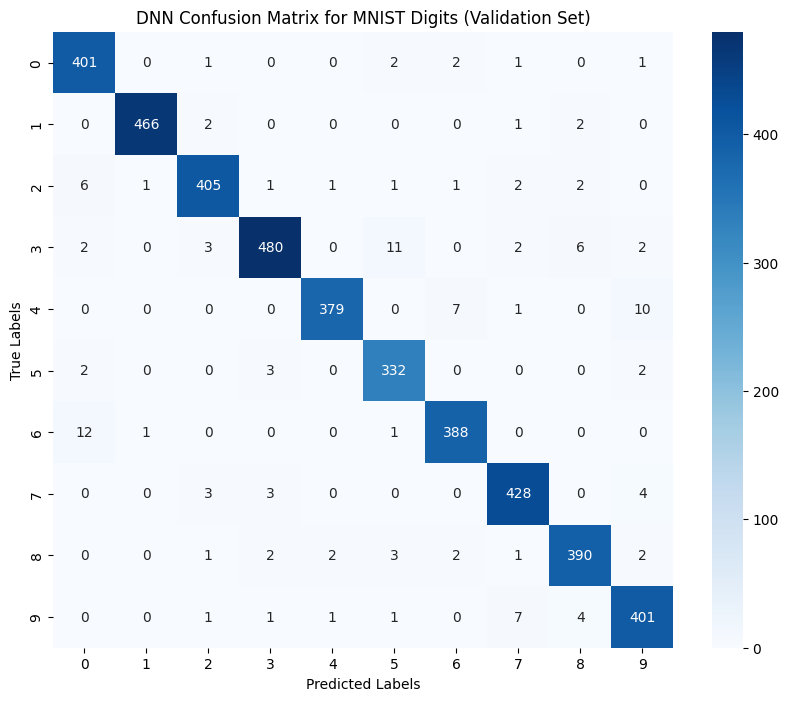

In [19]:
# Step 1: Make Predictions
y_pred = np.argmax(DNN_model.predict(x_val), axis=1)  # Predictions on validation set

# Check predictions and true labels
print("Predictions:", y_pred[:10])
print("True Labels:", y_val[:10])

# Step 2: Create the Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Step 3: Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('DNN Confusion Matrix for MNIST Digits (Validation Set)')
plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predictions: [8 1 9 9 8 6 2 2 7 1]
True Labels: [8 1 9 9 8 6 2 2 7 1]


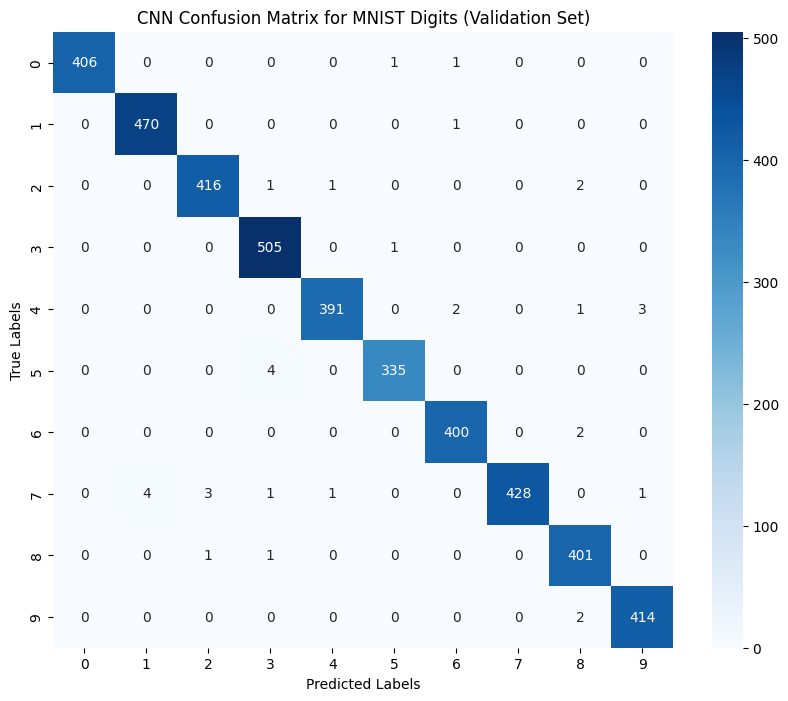

In [20]:
# Step 1: Make Predictions
y_pred = np.argmax(CNN_model.predict(x_val), axis=1)  # Predictions on validation set

# Check predictions and true labels
print("Predictions:", y_pred[:10])
print("True Labels:", y_val[:10])

# Step 2: Create the Confusion Matrix
cm = confusion_matrix(y_val, y_pred)

# Step 3: Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('CNN Confusion Matrix for MNIST Digits (Validation Set)')
plt.show()

Above, are the confusion matrices for both DNN and CNN, along with first ten of the labels for data check

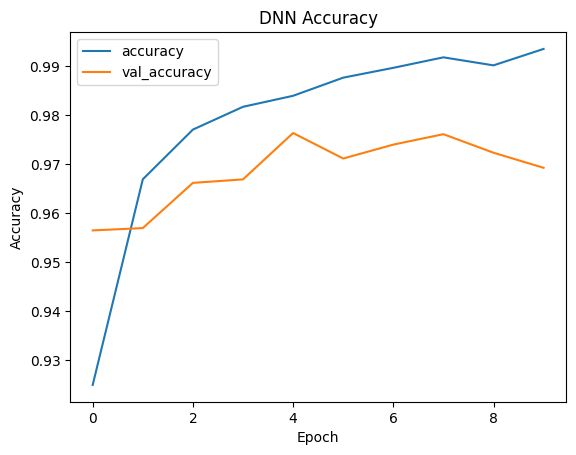

In [21]:
plt.title("DNN Accuracy")
plt.plot(DNN_history.history['custom_accuracy'], label='accuracy')
plt.plot(DNN_history.history['val_custom_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

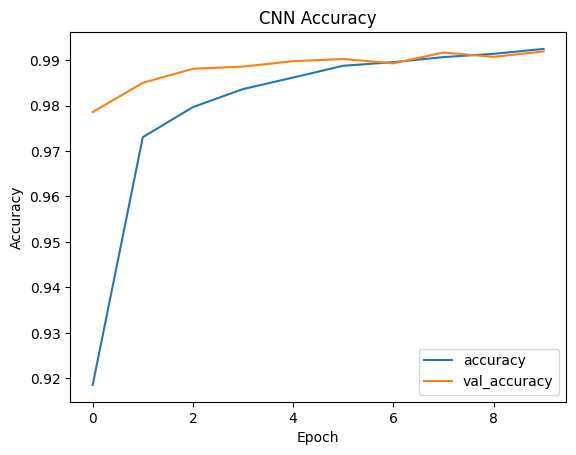

In [22]:
plt.title("CNN Accuracy")
plt.plot(CNN_history.history['accuracy'], label='accuracy')
plt.plot(CNN_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Using multiple model for comparison can get confusing but it's matter of making sure model name is correct. Also notice DNN uses custom accuracy which is optional

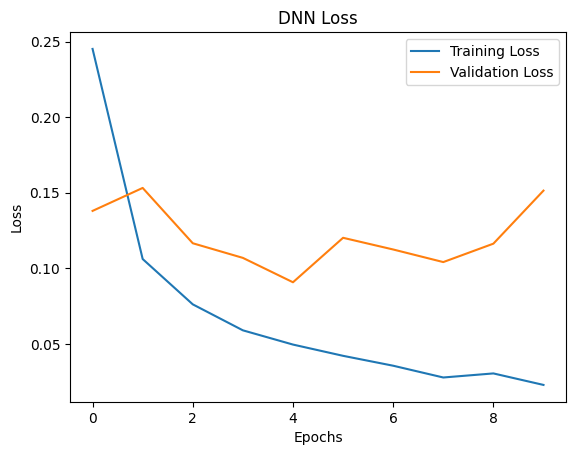

In [23]:
plt.title("DNN Loss")
plt.plot(DNN_history.history['loss'], label='Training Loss')
plt.plot(DNN_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

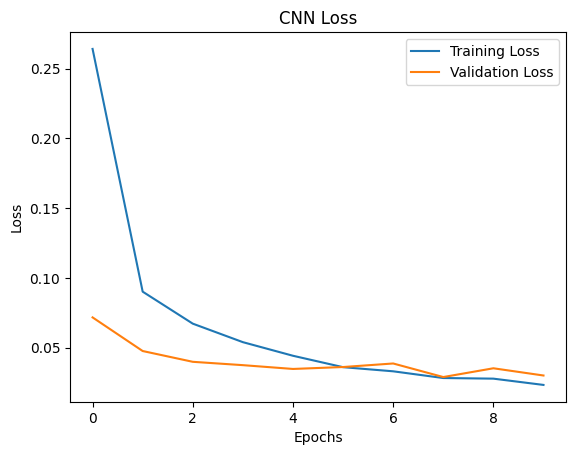

In [24]:
plt.title("CNN Loss")
plt.plot(CNN_history.history['loss'], label='Training Loss')
plt.plot(CNN_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Above, training and validation must be similar to be considered effective model, but as you can see CNN matches to that expectation but DNN less so but still is decent. This means that DNN model can further be improved and reduce overfitting by reducing parameter and replace with effective combination of layers.

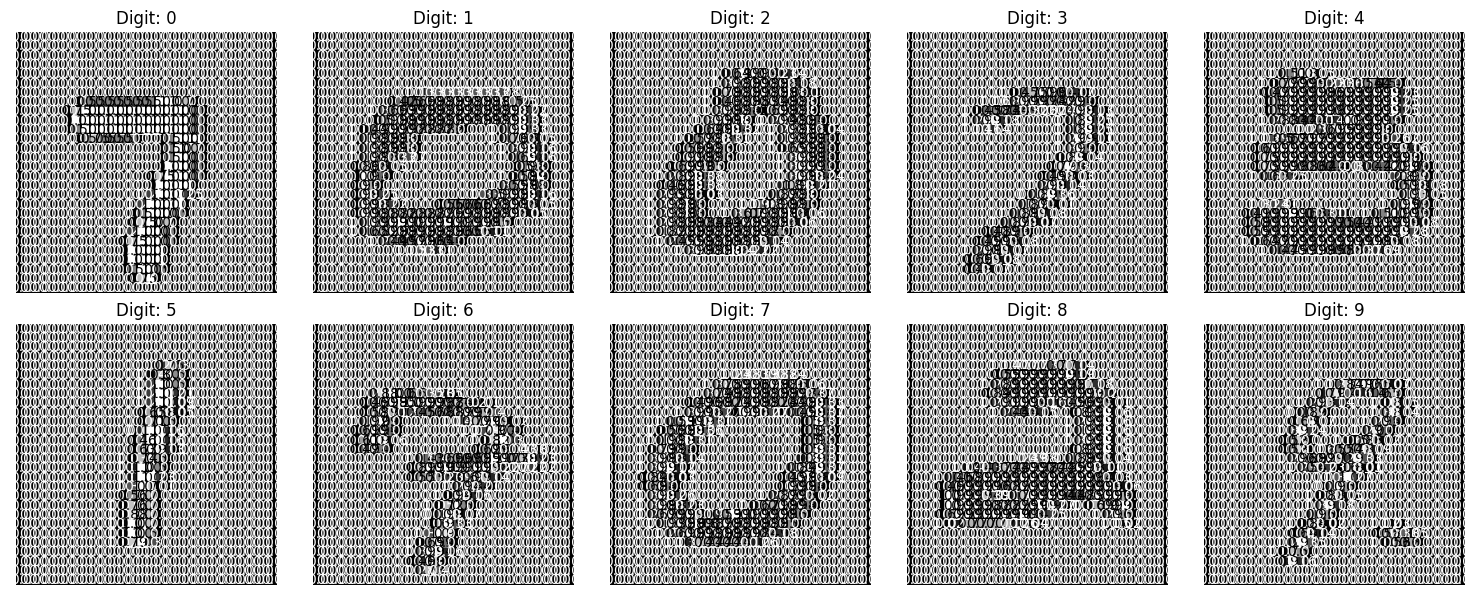

In [25]:
# Function to visualize MNIST images with pixel values annotated
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y] < thresh else 'black')

# Find the first occurrence index of each digit from 0 to 9 in the test set
digit_indices = [np.where(y_val == i)[0][0] for i in range(10)]

# Plot each digit with pixel values
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = x_test[digit_indices[i]]
    visualize_input(img, ax)
    ax.set_title(f"Digit: {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

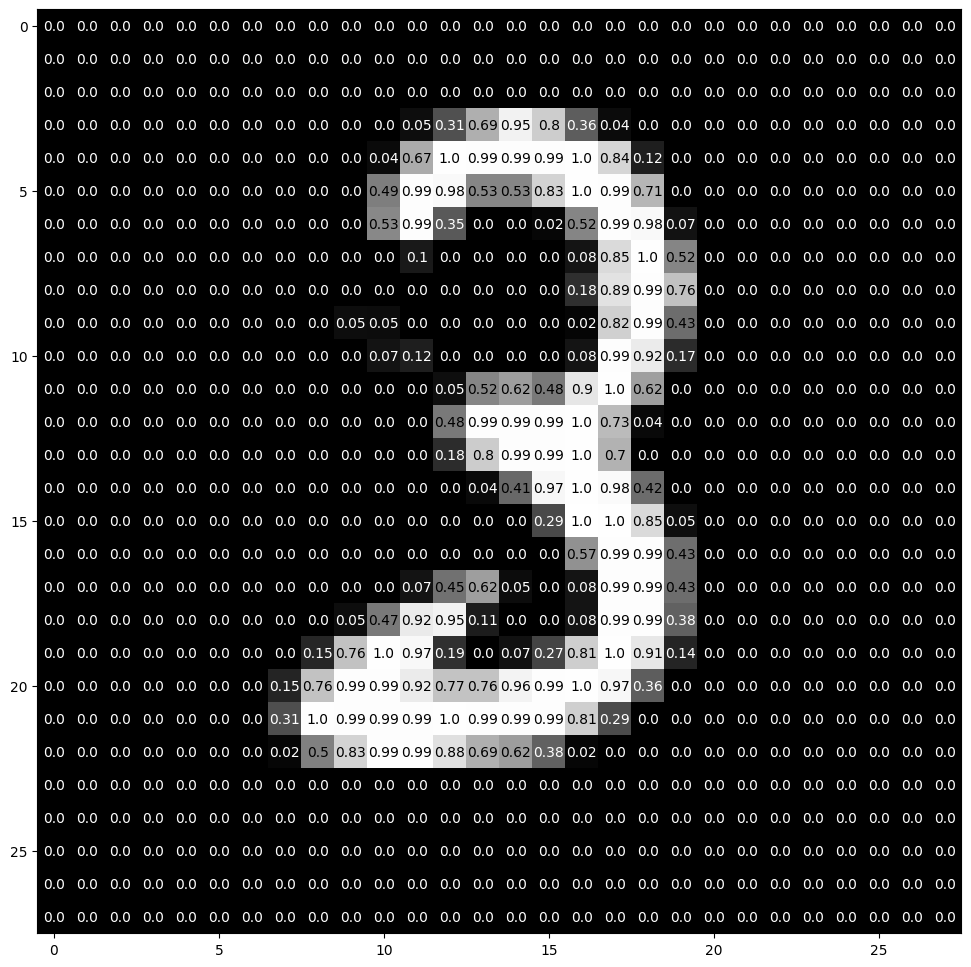

In [26]:
# visualize number using x_test[start:end]
fig = plt.figure(figsize = (12,12))   # size of the figure
ax = fig.add_subplot(111)           # size of the subplot
visualize_input(x_test[4:5].reshape(28,28), ax)

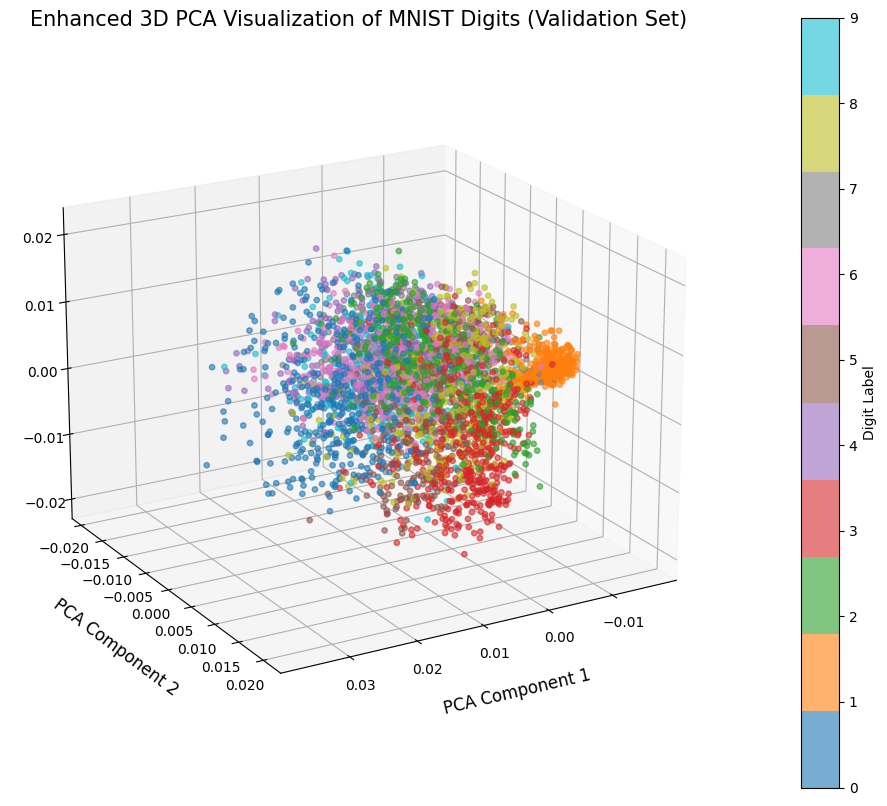

In [27]:
# Flatten and normalize the validation data
x_val_flat = x_val.reshape(x_val.shape[0], -1) / 255.0

# Apply PCA to reduce the dimensions to 3
pca = PCA(n_components=3)
x_val_pca = pca.fit_transform(x_val_flat)

# Create a 3D scatter plot with optimized visualization settings
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Define the color palette with 10 distinct colors
palette = sns.color_palette("tab10", 10)

# Scatter plot with color-coding based on digit labels, adjusted marker size and transparency
scatter = ax.scatter(x_val_pca[:, 0], x_val_pca[:, 1], x_val_pca[:, 2],
                     c=y_val, cmap='tab10', marker='o', alpha=0.6, s=15)

# Color bar with digit labels
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, ticks=range(10))
cbar.set_label('Digit Label')
cbar.set_ticks(range(10))
cbar.set_ticklabels(range(10))

# Set labels and title with improved styling
ax.set_xlabel('PCA Component 1', labelpad=15, fontsize=12)
ax.set_ylabel('PCA Component 2', labelpad=15, fontsize=12)
ax.set_zlabel('PCA Component 3', labelpad=15, fontsize=12)
ax.set_title('Enhanced 3D PCA Visualization of MNIST Digits (Validation Set)', fontsize=15, pad=20)

# Adjust viewing angle for better perspective
ax.view_init(elev=20, azim=60)

plt.show()

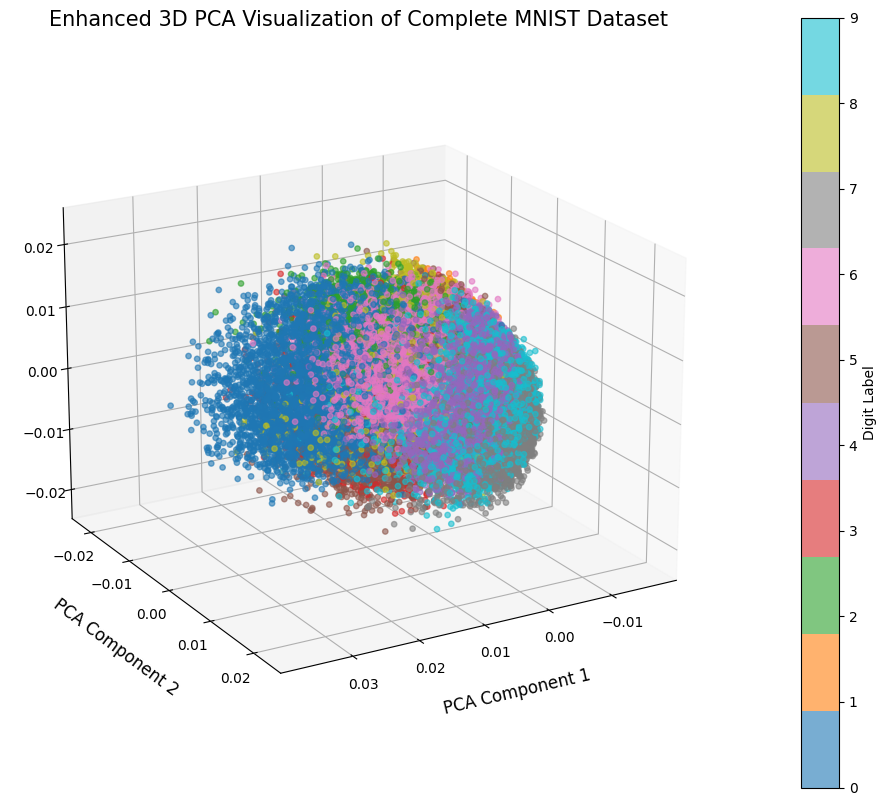

In [28]:
# Combine x_train and x_val, and y_train and y_val
x_combined = np.concatenate([x_train, x_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)

# Flatten and normalize the combined dataset
x_combined_flat = x_combined.reshape(x_combined.shape[0], -1) / 255.0

# Apply PCA to reduce the data to 3 dimensions
pca = PCA(n_components=3)
x_combined_pca = pca.fit_transform(x_combined_flat)

# Create a 3D scatter plot with enhanced visualization settings
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Define the color palette with 10 distinct colors
palette = sns.color_palette("tab10", 10)

# Scatter plot with color-coding based on the digit labels, adjusted marker size and transparency
scatter = ax.scatter(x_combined_pca[:, 0], x_combined_pca[:, 1], x_combined_pca[:, 2],
                     c=y_combined, cmap='tab10', marker='o', alpha=0.6, s=15)

# Color bar with digit labels
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, ticks=range(10))
cbar.set_label('Digit Label')
cbar.set_ticks(range(10))
cbar.set_ticklabels(range(10))

# Set labels and title with improved styling
ax.set_xlabel('PCA Component 1', labelpad=15, fontsize=12)
ax.set_ylabel('PCA Component 2', labelpad=15, fontsize=12)
ax.set_zlabel('PCA Component 3', labelpad=15, fontsize=12)
ax.set_title('Enhanced 3D PCA Visualization of Complete MNIST Dataset', fontsize=15, pad=20)

# Adjust viewing angle for better perspective
ax.view_init(elev=20, azim=60)

plt.show()

In [29]:
# Flatten and normalize the validation data
x_val_flat = x_val.reshape(x_val.shape[0], -1) / 255.0  # Flatten and normalize

# Apply UMAP with optimized parameters on the validation set
umap_model = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
x_val_umap = umap_model.fit_transform(x_val_flat)

# Create an interactive 3D scatter plot with Plotly
fig = px.scatter_3d(
    x=x_val_umap[:, 0],
    y=x_val_umap[:, 1],
    z=x_val_umap[:, 2],
    color=y_val.astype(str),  # Convert to string for categorical coloring
    title="3D UMAP Visualization of MNIST Validation Set",
    labels={'color': 'Digit Label'},
    hover_name=y_val.astype(str),  # Shows the digit label on hover
    color_discrete_sequence=px.colors.qualitative.Set1  # Set color palette for distinct colors
)

# Adjust marker size, transparency, and layout
fig.update_traces(marker=dict(size=3, opacity=0.75))  # Smaller, semi-transparent markers
fig.update_layout(scene=dict(
    xaxis_title='UMAP Component 1',
    yaxis_title='UMAP Component 2',
    zaxis_title='UMAP Component 3',
    xaxis=dict(showbackground=False),
    yaxis=dict(showbackground=False),
    zaxis=dict(showbackground=False),
), margin=dict(l=0, r=0, b=0, t=40))

# Show plot
fig.show()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


This visualization doens't have much meaning for this dataset but it's nonetheless very interesting to visually see. Each of the digit labels are clustered and some digit labels are scattered everywhere. Closer the label to eachother are the similar the labels are and can be potential reason of misclassifying some samples. 

## Insights and Recommendations (Last Edit 10/10/24)
### Insights
Every testing, CNN outperforms in all by having higher accuracy, lower loss, higher validation accuracy, lower validation loss

Label 5's and 9's are with lowest performing in predicting labels, having improved labels may increase overall accuracy

Fully dense neural network and CNN both performs very well with near 100% accuracy, but CNN still outperforms in accuracy and loss rate slightly

Data Characteristics: The MNIST dataset consists of 70,000 handwritten digit images (0-9), each 28x28 pixels, providing a clear and structured format for classification tasks.

Class Imbalance: While the dataset is relatively balanced, slight variations in digit frequency may affect model training. Understanding this can guide your evaluation metrics.

Impact of Noise: MNIST images can contain noise (e.g., variations in handwriting). Robust models can handle this noise, making data augmentation beneficial during training.

### Recommendations
Plan the possible models, evaluation, metrics, activation function, loss function, and visualization before building the model to give a general vision of the notebook

Start with Simple Models: Begin with a basic neural network architecture (e.g., one hidden layer) to understand the fundamentals before adding complexity.

Implement Data Normalization: Normalize pixel values (0-255) to a range of 0-1 to improve training stability and speed.

Use Early Stopping: Monitor the validation loss during training and implement early stopping to prevent overfitting when performance on the validation set starts to decline.

### Tips (Last Edit 10/10/24)
Make sure to name the models that is easy to follow especially when creating multiple models. If CNN do CNN_model, if base DNN do DNN_model, and do place all models within each steps to avoid having to scroll through for another model with the same step

Install the right version for each ML projects! Or simply it won't work as intended after few months, by saving library version to requirements.txt it will save the headache of accessing the project again in the future for reference since fundamentals will remain even after version update

When warning signs show up, potentially the version is not aligned, do ex. pip install --upgrade tensorflow keras

Plan out the layers to build before hand, it will save a lot of time

Understand the model, each model will have different ways of interacting with layers, such as back propagation will move backward on layers to adjust weights until desirable outcome is made

Always have insights and recommendations! Learning from the data and model is crucial for every projects even including this one

Tensorflow version 2.16 and onward comes with Keras, which avoids the "ImportError: cannot import name 'flat_map_op' from 'tensorflow.python.data.ops"

### Notes from Kaggle (Last Edit 10/27/24)
After looking through multiple Kaggle works on MNIST dataset, I have not seen anyone using confusion matrix. Perhaps it's more important to look into accuracy and loss than individually or perhaps to reduce complexity by not going into details by pin pointing and correcting certain low quality handwritten data

From the kaggle search, I found a very interesting notebook which uses other methods than CNN for MNIST

https://www.kaggle.com/code/ohseokkim/mnist-let-s-see-it-from-a-new-perspective

Very well written Neural Netowrk from scratch

https://www.kaggle.com/code/soham1024/basic-neural-network-from-scratch-in-python

Unfortunately, I couldn't make umap work due to version issue https://pair-code.github.io/understanding-umap/ *fixed by upgrading numpy 1.24.0 to 1.26.4 and installing umap-learn and plotly

As much as exploration is possible for training and testing model to building an architecture for Deep Nueral Network, there is just as much possibilities for building visualization through UMAP